In [1]:
import pandas as pd

## Read train and test

In [2]:
X_train = pd.read_csv("/kaggle/input/last-one/eagle_data_all_completed_X_train.csv")
X_test = pd.read_csv("/kaggle/input/last-one/eagle_data_all_completed_X_test.csv")
    
y_train = pd.read_csv("/kaggle/input/last-one/eagle_data_all_completed_y_train.csv")['run_time']
y_test = pd.read_csv("/kaggle/input/last-one/eagle_data_all_completed_y_test.csv")['run_time']

In [4]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

## Evaluate DNN

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    median_absolute_error,
)
import pandas as pd
import numpy as np

def evaluate_model(model, X, y, label, raw_X=None, scaler=None):
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()
    elif isinstance(y, np.ndarray):
        y = pd.Series(y)

    y_pred_scaled = model.predict(X).flatten()
    if scaler:
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    else:
        y_pred = y_pred_scaled

    y_pred = pd.Series(y_pred, index=y.index)


    # Main line plot
    plt.figure(figsize=(14, 5))
    plt.plot(y.values, label="Actual", color='gold')
    plt.plot(y_pred, label="Predicted", color='limegreen', linestyle='--', alpha=0.4)
    plt.title("Aligned Predicted vs Actual Job Runtimes")
    plt.xlabel("Job Index")
    plt.ylabel("Runtime")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"\n----- {label} (All Jobs) -----")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean actual: {np.mean(y):.2f}")
    print("y shape:", y.shape)
    print("y_pred shape:", y_pred.shape)

    # --- Acceptance zone (runtime < predicted < wallclock)
    wallclock = raw_X['wallclock_req']
    # Conditions
    accepted = (y <= y_pred) & (y_pred < wallclock)  # adjust wallclock if defined
    under = y_pred < y
    over = y_pred > wallclock  # adjust as needed
    tolerance = 1e-6
    exact = (y_pred >= y) & (y_pred <= y + tolerance)
    # floating point safe equality
    negative = y_pred < 0

    # Percentages
    total = len(y)
    pct_accepted = 100 * accepted.sum() / total
    pct_under = 100 * under.sum() / total
    pct_over = 100 * over.sum() / total
    pct_exact = 100 * exact.sum() / total
    pct_negative = 100 * negative.sum() / total

    # Plot
    plt.figure(figsize=(9, 6))
    plt.scatter(y_pred[accepted], y[accepted], color='limegreen',
                label=f'Accepted ({pct_accepted:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[under], y[under], color='red',
                label=f'Underestimated ({pct_under:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[over], y[over], color='orange',
                label=f'Overestimated ({pct_over:.1f}%)', alpha=0.7)
    if exact.sum() > 0:
        plt.scatter(y_pred[exact], y[exact], color='blue', marker='x',
                    label=f'Exact Match ({pct_exact:.2f}%)', alpha=0.9)
    if negative.sum() > 0:
        plt.scatter(y_pred[negative], y[negative], color='black', marker='v',
                    label=f'Negative Prediction ({pct_negative:.2f}%)', alpha=0.9)

    # Decorations
    plt.xlabel("Predicted Runtime")
    plt.ylabel("Actual Runtime")
    plt.title("Prediction Zones")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Job length stats
    if 'job_length' in raw_X.columns:
        print("\n----- Per Job length Evaluation -----")
        for jl in sorted(raw_X['job_length'].unique()):
            idx = raw_X['job_length'] == jl
            print(f"\n[Job Length {jl}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_pred, y=y, hue=raw_X["job_length"], alpha=0.8)
        max_val = max(y.max(), y_pred.max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Predicted Runtime (log)")
        plt.ylabel("Actual Runtime (log)")
        plt.title("Predicted vs Actual by Job Length")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Job type stats
    if 'job_type' in raw_X.columns:
        print("\n----- Per Job type Evaluation -----")
        for jt in sorted(raw_X['job_type'].unique()):
            idx = raw_X['job_type'] == jt
            print(f"\n[Job Type {jt}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

    # Time-based plots
    raw_X = raw_X.copy()
    raw_X['submit_time'] = pd.to_datetime(raw_X['submit_time'], unit='s', errors='coerce')
    df_temp = pd.DataFrame({
        'submit_time': raw_X['submit_time'],
        'actual': y,
        'predicted': y_pred,
        'wallclock': wallclock
    })

    if 'x_test' in label.lower():
        df_temp['day'] = df_temp['submit_time'].dt.date
        for day, group in df_temp.groupby('day'):
            print(f"\n--- Day: {day} | Samples: {len(group)} ---")

            # Plot 1: MAE Line Plot
            abs_errors = np.abs(group['actual'] - group['predicted'])
            plt.figure(figsize=(8, 4))
            plt.plot(abs_errors.values, color='crimson')
            plt.title(f"Absolute Error per Job for {day}")
            plt.xlabel("Job Index")
            plt.ylabel("Absolute Error")
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Plot 2: Runtime Comparison (first 40)
            n = min(40, len(group))
            plt.figure(figsize=(10, 5))
            plt.plot(range(n), group['actual'].values[:n], label='Actual', marker='o', color='gold')
            plt.plot(range(n), group['predicted'].values[:n], label='Predicted', marker='s', linestyle='--', color='limegreen')
            plt.plot(range(n), group['wallclock'].values[:n], label='Wallclock', marker='^', linestyle=':', color='skyblue')
            plt.title(f"Runtime Comparison for {day} (First {n} Jobs)")
            plt.xlabel("Job Index")
            plt.ylabel("Runtime (seconds)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.yscale('log')
            plt.show()

    else:
        df_temp['week'] = df_temp['submit_time'].dt.to_period('W').dt.start_time
        mae_over_time = []
        for week, group in df_temp.groupby('week'):
            mae = mean_absolute_error(group['actual'], group['predicted'])
            mae_over_time.append((week, mae))

        if mae_over_time:
            weeks, maes = zip(*mae_over_time)
            plt.figure(figsize=(10, 5))
            plt.plot(weeks, maes, marker='o', color='purple')
            plt.title("MAE over Time (Weekly)")
            plt.xlabel("Week")
            plt.ylabel("MAE")
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Final comparison of actual vs predicted vs wallclock (first 80)
        n = 80
        plt.figure(figsize=(12, 6))
        plt.plot(range(n), y[:n], label="Actual", color="gold", marker="o")
        plt.plot(range(n), y_pred[:n], label="Predicted", color="limegreen", linestyle="--", marker="s")
        plt.plot(range(n), df_temp['wallclock'][:n], label="Wallclock", color="skyblue", linestyle=":", marker="^")
        plt.title(f"Comparison of Actual, Predicted, and Wallclock Runtimes (First {n} Jobs)")
        plt.xlabel("Job Index")
        plt.ylabel("Runtime (seconds)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()

    # Negative predictions
    y_pred_series = pd.Series(y_pred, index=X.index)
    negative_idx = y_pred_series[y_pred_series < 0].index
    negative_features = X.loc[negative_idx].copy()
    negative_features['prediction'] = y_pred_series.loc[negative_idx]
    print(f"Number of negative predictions: {len(negative_features)}")
    print(negative_features.head())


In [ ]:
# pip install keras-tuner --quiet

## Tarin DNN

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 130.1823 - mse: 1.0201 - val_loss: 1.3116 - val_mse: 0.8028 - learning_rate: 0.0010
Epoch 2/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0040 - mse: 0.6352 - val_loss: 0.7955 - val_mse: 0.5844 - learning_rate: 0.0010
Epoch 3/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8094 - mse: 0.5956 - val_loss: 0.6983 - val_mse: 0.5966 - learning_rate: 0.0010
Epoch 4/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6785 - mse: 0.5708 - val_loss: 0.6224 - val_mse: 0.5677 - learning_rate: 0.0010
Epoch 5/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6405 - mse: 0.5580 - val_loss: 0.6894 - val_mse: 0.6197 - learning_rate: 0.0010
Epoch 6/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6452 - mse: 0.5587 - val_loss: 0.6416 - val_mse: 0.5721 - learning_rate: 0.0010
Epoch 7/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6291 - mse: 0.5583 - val_loss: 0.6293 - val_mse: 0.5552 - learning_rate: 0.0010
Epoch 8/

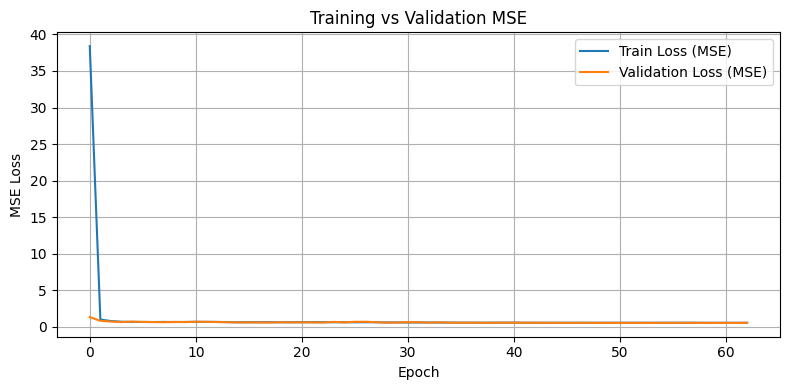

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------- Feature selection ---------

# f = ['partition_wallclock', 'cum_te_partition_qos', 'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema']

# f= ['partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema', 'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem']

f = ['job_id', 'qos', 'gpus_req', 'user_account_name', 
     'processors_req_nodes', 'nodes_req_mem', 'processors_req_mem', 
     'partition_wallclock']

X_train_final = X_train[f]
X_test_final = X_test[f]

# --------- Manual train/val split ---------
split_idx = int(len(X_train_final) * 0.9)
X_train_part = X_train_final.iloc[:split_idx]
y_train_part = y_train.iloc[:split_idx]
X_val_part = X_train_final.iloc[split_idx:]
y_val_part = y_train.iloc[split_idx:]

# --------- Feature scaling ---------
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_part)
X_val_scaled = X_scaler.transform(X_val_part)
X_test_scaled = X_scaler.transform(X_test_final)

# --------- Target scaling ---------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_part.values.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val_part.values.reshape(-1, 1)).flatten()

# --------- Build DNN model ---------
model_ann = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(1)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation='relu', kernel_regularizer=l2(1)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu', kernel_regularizer=l2(1)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(1)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_regularizer=l2(1)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)
])

# --------- Learning rate scheduler ---------
def scheduler(epoch, lr):
    return lr if epoch < 5 else lr * tf.math.exp(-0.01)

lr_scheduler = LearningRateScheduler(scheduler)

# --------- Compile model (MSE loss + MSE metric) ---------
model_ann.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mse'])

# --------- Callbacks ---------
early_stop = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=5, verbose=1, mode='min', min_lr=1e-6)

import time  # Add this at the top with your imports

# --------- Model training ---------
start_time = time.time()  # ⏱️ Start timer

history = model_ann.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    shuffle=False
)

end_time = time.time()  # ⏱️ End timer
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# --------- Predict and inverse-scale test ---------
y_pred_scaled = model_ann.predict(X_test_scaled).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# --------- Test evaluation ---------
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

# --------- Train evaluation ---------
y_train_pred_scaled = model_ann.predict(X_train_scaled).flatten()
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

train_r2 = r2_score(y_train_part, y_train_pred)
train_mae = mean_absolute_error(y_train_part, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_part, y_train_pred))
print(f"Train R² Score: {train_r2:.4f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")

# --------- Plot training history ---------
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature importance

In [ ]:
# from sklearn.metrics import mean_absolute_error
# import copy

# baseline_mae = mean_absolute_error(y_test, y_pred)
# importances = []

# for i, col in enumerate(X_test_final.columns):
#     X_test_permuted = X_test_final.copy()
#     X_test_permuted[col] = np.random.permutation(X_test_permuted[col])

#     X_test_scaled_permuted = X_scaler.transform(X_test_permuted)
#     y_pred_permuted = model_ann.predict(X_test_scaled_permuted).flatten()
#     y_pred_permuted = y_scaler.inverse_transform(y_pred_permuted.reshape(-1, 1)).flatten()

#     permuted_mae = mean_absolute_error(y_test, y_pred_permuted)
#     importance = permuted_mae - baseline_mae
#     importances.append((col, importance))

# # Sort and display
# importances = sorted(importances, key=lambda x: -x[1])
# print("🔍 Feature importances (Permutation):")
# for name, imp in importances:
#     print(f"{name}: {imp:.2f}")

## Load and test

573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


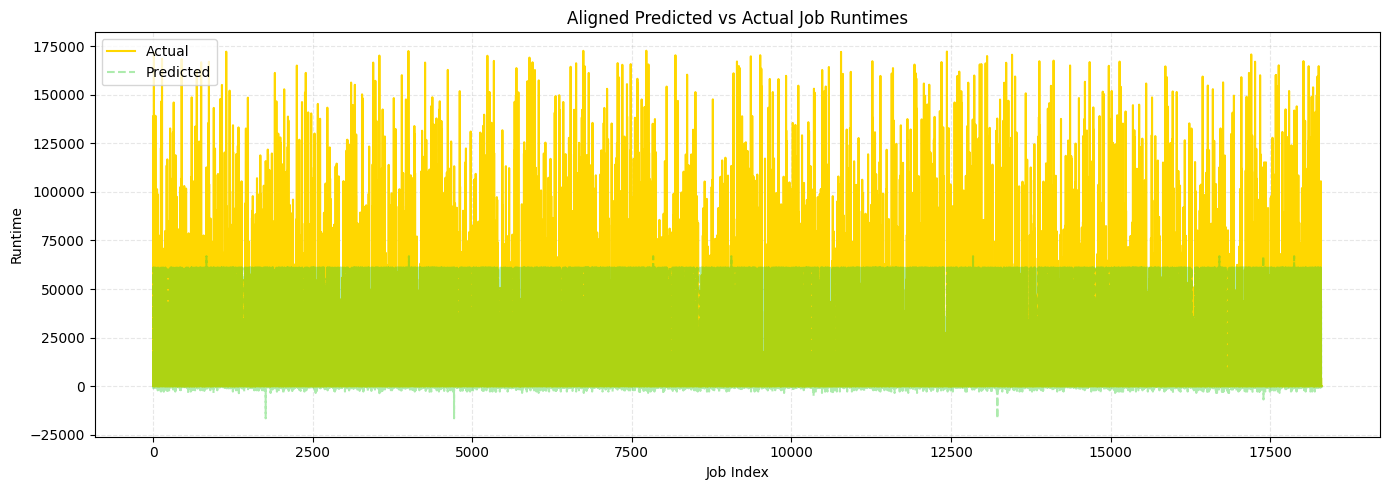


----- x_train (All Jobs) -----
R² Score: 0.539
MAE: 9476.01
RMSE: 21329.81
Mean actual: 13816.37
y shape: (18306,)
y_pred shape: (18306,)


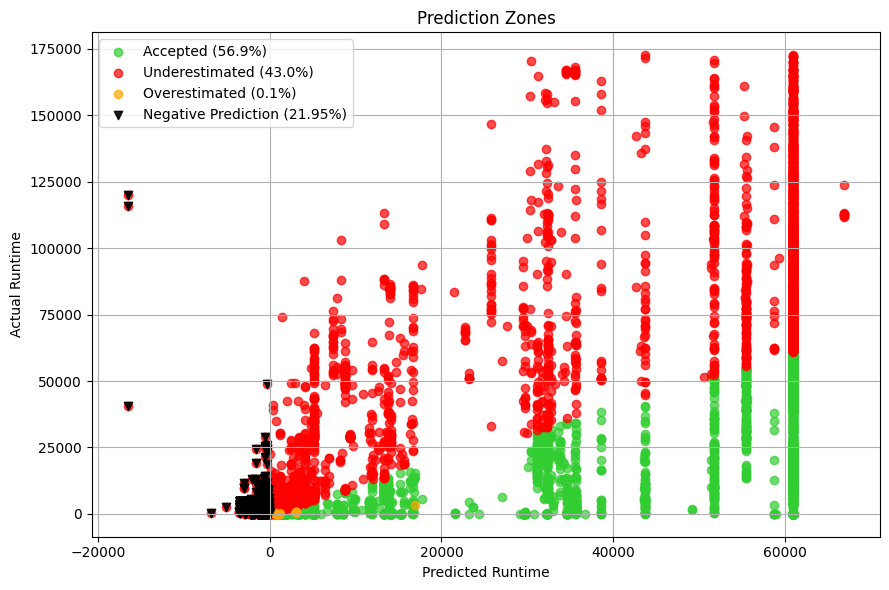


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.335
  MAE: 24309.07
  RMSE: 35071.18
  Samples: 5415

[Job Length medium]
  R²: -251.087
  MAE: 3282.79
  RMSE: 8131.97
  Samples: 1375

[Job Length short]
  R²: -9406.425
  MAE: 3240.74
  RMSE: 11702.86
  Samples: 11516


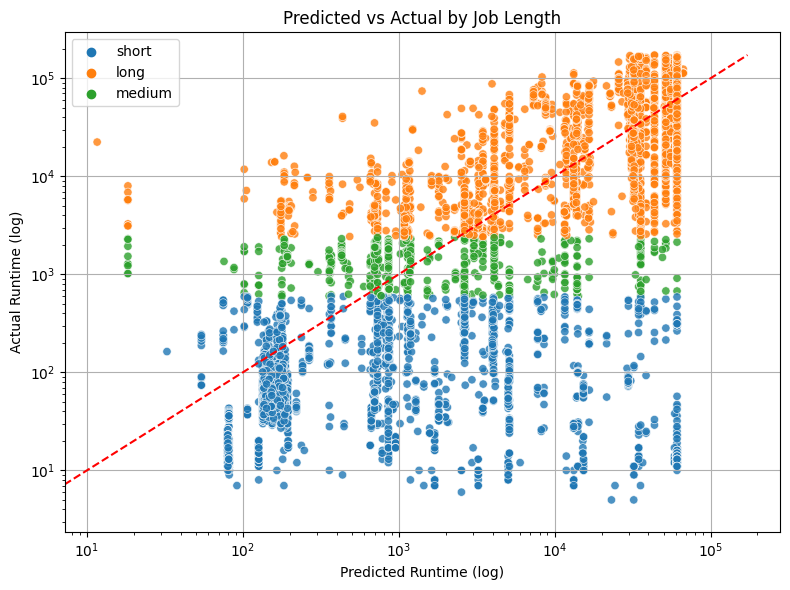


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: 0.182
  MAE: 17981.83
  RMSE: 32060.27
  Samples: 904

[Job Type distributed_gpu]
  R²: -0.623
  MAE: 5800.59
  RMSE: 8873.06
  Samples: 35

[Job Type multithreaded]
  R²: 0.437
  MAE: 21930.82
  RMSE: 33996.80
  Samples: 5085

[Job Type serial]
  R²: 0.492
  MAE: 3731.02
  RMSE: 11141.10
  Samples: 11854

[Job Type single_node_gpu]
  R²: 0.665
  MAE: 2952.03
  RMSE: 10595.23
  Samples: 428


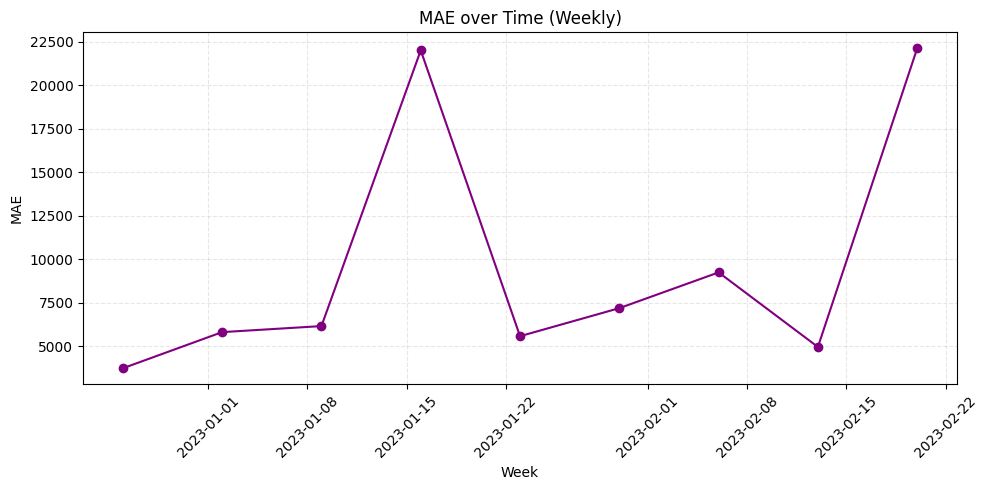

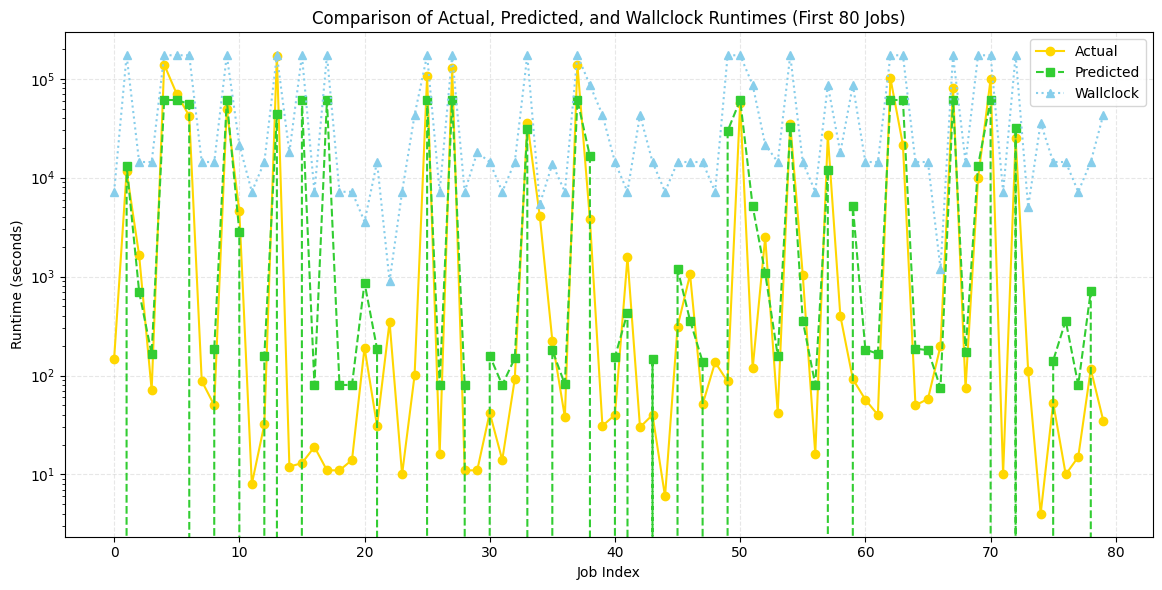

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [10]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import joblib

# Load the saved model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Huber

# Load model with custom loss and metrics
loaded_model = load_model(
    'model_DNN_lassoFeatures_1.h5',
    custom_objects={
        # 'rmse': rmse,
        'Huber': Huber,
        'mse': tf.keras.losses.MeanSquaredError()
    }
)

X_scaler = joblib.load('X_scaler_1.pkl')
y_scaler = joblib.load('y_scaler_1.pkl')

# --------- Feature selection ---------
f = ['job_id', 'qos', 'gpus_req', 'user_account_name', 
     'processors_req_nodes', 'nodes_req_mem', 'processors_req_mem', 
     'partition_wallclock']

# f = ['partition_wallclock', 'cum_te_partition_qos', 'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema']


X_train_final = X_train[f]
X_test_final = X_test[f]

X_train_scaled = X_scaler.transform(X_train_final)  # X_new should have same columns as the original training data
X_test_scaled = X_scaler.transform(X_test_final)  # X_new should have same columns as the original training data


evaluate_model(loaded_model, X_train_scaled, y_train, "x_train", X_train, y_scaler)
evaluate_model(loaded_model, X_test_scaled, y_test, "x_test", X_test, y_scaler)


## Save (model + scalers) for later use

In [34]:
# Save the entire model to a single file (HDF5 format)
model_ann.save('model_DNN_lassoFeatures_1.h5')
import joblib

# Suppose you used these
joblib.dump(X_scaler, 'X_scaler_1.pkl')
joblib.dump(y_scaler, 'y_scaler_1.pkl')


['y_scaler_1.pkl']

## Evaluate RNN

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error
)
import numpy as np
import pandas as pd

def evaluate_rnn_model(model, X, y_true, label='', scaler_y=None, raw_X=None):
    # --------- Prédiction ---------
    y_pred_scaled = model.predict(X).flatten()
    if scaler_y:
        y_pred = np.expm1(scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten())
    else:
        y_pred = y_pred_scaled

    y_true = y_true.values.flatten()
    y_pred = np.array(y_pred)

    # Corriger raw_X si taille incompatible
    if raw_X is not None and len(raw_X) != len(y_true):
        print("\u26a0\ufe0f raw_X trimmed to match y_true shape.")
        raw_X = raw_X.iloc[:len(y_true)].copy()

    # --------- Évaluation globale ---------
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)

    print(f"\n------ Evaluation: {label} ------")
    print(f"MAE       : {mae:.2f}")
    print(f"RMSE      : {rmse:.2f}")
    print(f"R²        : {r2:.3f}")
    print(f"MedAE     : {medae:.2f}")
    print(f"Mean true : {np.mean(y_true):.2f}")
    print(f"Total samples: {len(y_true)}")

    # --------- Nombre de prédictions négatives ---------
    num_negative = np.sum(y_pred < 0)
    print(f"\n\u26a0\ufe0f  {num_negative} negative predictions ({100 * num_negative / len(y_pred):.2f}%)")

    # --------- Main plot ---------
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label="Actual", color='gold')
    plt.plot(y_pred, label="Predicted", color='limegreen', linestyle='--', alpha=0.7)
    plt.title("Aligned Predicted vs Actual Job Runtimes")
    plt.xlabel("Job Index")
    plt.ylabel("Runtime")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------- Zone d'acceptation ---------
    wallclock = raw_X['wallclock_req']
    accepted = (y_pred > y_true) & (y_pred < wallclock)
    under = y_pred <= y_true
    over = y_pred >= wallclock

    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:50], label='True Values', color='blue', linewidth=2)
    plt.plot(y_pred[:50], label='Predicted Values', color='red', linestyle='--', linewidth=2)
    plt.xlabel("Sample Index (First 50)")
    plt.ylabel("Runtime")
    plt.legend()
    plt.grid(True)
    plt.title("True vs Predicted Values (First 50)")
    plt.tight_layout()
    plt.show()

    total = len(y_true)
    pct_accepted = 100 * accepted.sum() / total
    pct_under = 100 * under.sum() / total
    pct_over = 100 * over.sum() / total

    plt.figure(figsize=(9, 6))
    plt.scatter(y_pred[accepted], y_true[accepted], color='limegreen', label=f'Accepted ({pct_accepted:.1f}%)', alpha=0.4)
    plt.scatter(y_pred[under], y_true[under], color='red', label=f'Underestimated ({pct_under:.1f}%)', alpha=0.4)
    plt.scatter(y_pred[over], y_true[over], color='orange', label=f'Overestimated ({pct_over:.1f}%)', alpha=0.4)
    max_val = max(y_pred.max(), y_true.max()) * 1.05
    plt.plot([0, max_val], [0, max_val], 'k--', label='y = x')
    plt.xlabel("Predicted Runtime (sec)")
    plt.ylabel("Actual Runtime (sec)")
    plt.title("Prediction vs Actual Runtime (Acceptance Conditions)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------- Job length analysis ---------
    if 'job_length' in raw_X.columns:
        print("\n----- Per Job length Evaluation -----")
        for jl in sorted(raw_X['job_length'].unique()):
            idx = raw_X['job_length'] == jl
            print(f"\n[Job Length {jl}]")
            print(f"  R²: {r2_score(y_true[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y_true[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_pred, y=y_true, hue=raw_X["job_length"], alpha=0.1)
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Predicted Runtime (log)")
        plt.ylabel("Actual Runtime (log)")
        plt.title("Predicted vs Actual by Job Length")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # --------- Job type analysis ---------
    if 'job_type' in raw_X.columns:
        print("\n----- Per Job type Evaluation -----")
        for jt in sorted(raw_X['job_type'].unique()):
            idx = raw_X['job_type'] == jt
            print(f"\n[Job Type {jt}]")
            print(f"  R²: {r2_score(y_true[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y_true[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

    # --------- Time-based MAE & Comparison ---------
    raw_X = raw_X.copy()
    raw_X['submit_time'] = pd.to_datetime(raw_X['submit_time'], unit='s', errors='coerce')
    df_temp = pd.DataFrame({
        'submit_time': raw_X['submit_time'],
        'actual': y_true,
        'predicted': y_pred,
        'wallclock': wallclock
    })

    if 'x_test' in label.lower():
        df_temp['day'] = df_temp['submit_time'].dt.date
        for day, group in df_temp.groupby('day'):
            print(f"\n--- Day: {day} | Samples: {len(group)} ---")

            # Plot 1: MAE per job
            abs_errors = np.abs(group['actual'] - group['predicted'])
            plt.figure(figsize=(8, 4))
            plt.plot(abs_errors.values, color='crimson')
            plt.title(f"Absolute Error per Job for {day}")
            plt.xlabel("Job Index")
            plt.ylabel("Absolute Error")
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Plot 2: Runtime Comparison
            n = min(40, len(group))
            plt.figure(figsize=(10, 5))
            plt.plot(range(n), group['actual'].values[:n], label='Actual', marker='o', color='gold')
            plt.plot(range(n), group['predicted'].values[:n], label='Predicted', marker='s', linestyle='--', color='limegreen')
            plt.plot(range(n), group['wallclock'].values[:n], label='Wallclock', marker='^', linestyle=':', color='skyblue')
            plt.title(f"Runtime Comparison for {day} (First {n} Jobs)")
            plt.xlabel("Job Index")
            plt.ylabel("Runtime (seconds)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.yscale('log')
            plt.show()
    else:
        df_temp['week'] = df_temp['submit_time'].dt.to_period('W').dt.start_time
        mae_over_time = []
        for week, group in df_temp.groupby('week'):
            mae = mean_absolute_error(group['actual'], group['predicted'])
            mae_over_time.append((week, mae))

        if mae_over_time:
            weeks, maes = zip(*mae_over_time)
            plt.figure(figsize=(10, 5))
            plt.plot(weeks, maes, marker='o', color='purple')
            plt.title("MAE over Time (Weekly)")
            plt.xlabel("Week")
            plt.ylabel("MAE")
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Final comparison
        n = 80
        plt.figure(figsize=(12, 6))
        plt.plot(range(n), y_true[:n], label="Actual", color="gold", marker="o")
        plt.plot(range(n), y_pred[:n], label="Predicted", color="limegreen", linestyle="--", marker="s")
        plt.plot(range(n), df_temp['wallclock'][:n], label="Wallclock", color="skyblue", linestyle=":", marker="^")
        plt.title(f"Comparison of Actual, Predicted, and Wallclock Runtimes (First {n} Jobs)")
        plt.xlabel("Job Index")
        plt.ylabel("Runtime (seconds)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()

    # # --------- Négatives ---------
    # if isinstance(X, pd.DataFrame):
    #     negative_features = X.iloc[negative_idx].copy()
    # else:
    #     # If X is a NumPy array, flatten to 2D before converting
    #     X_2d = X.reshape(X.shape[0], -1)
    #     negative_features = pd.DataFrame(X_2d)[negative_idx].copy()

    # y_pred_series = pd.Series(y_pred)
    # negative_idx = y_pred_series[y_pred_series < 0].index
    
    # if isinstance(X, pd.DataFrame):
    #     negative_features = X.iloc[negative_idx].copy()
    # else:
    #     negative_features = pd.DataFrame(X)[negative_idx].copy()
    
    # negative_features['prediction'] = y_pred_series.loc[negative_idx]
    # print(f"Number of negative predictions: {len(negative_features)}")
    # print(negative_features.head())



## RNN LSTM (“Given the last 5 jobs’ characteristics, what is the likely run_time of the next job?”)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K

import os
import joblib
from tensorflow.keras.callbacks import Callback

class SaveModelAndScalers(Callback):
    def __init__(self, model_dir, x_scaler, y_scaler, save_freq=50):
        super().__init__()
        self.model_dir = model_dir
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        self.save_freq = save_freq
        os.makedirs(model_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            model_path = os.path.join(self.model_dir, f"model_epoch_{epoch+1}.h5")
            x_scaler_path = os.path.join(self.model_dir, f"x_scaler_epoch_{epoch+1}.pkl")
            y_scaler_path = os.path.join(self.model_dir, f"y_scaler_epoch_{epoch+1}.pkl")

            self.model.save(model_path)
            joblib.dump(self.x_scaler, x_scaler_path)
            joblib.dump(self.y_scaler, y_scaler_path)

            print(f"\n✅ Saved model and scalers at epoch {epoch+1}")



# Custom RMSE metric for Keras
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

f = ['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes',
'nodes_req_mem', 'processors_req_mem', 'partition_wallclock','last_run_time_1','last_run_time_2','last_run_time_3','last_run_time_4','last_run_time_5']

# f = ['partition_wallclock', 'cum_te_partition_qos', 'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema','last_run_time_1','last_run_time_2','last_run_time_3','last_run_time_4','last_run_time_5']

# f= ['partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema', 'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem']
# --- Select features ---
# Assuming 'f' is your list of selected features
X_train_final = X_train[f]
X_test_final = X_test[f]

# --- Manual time-sensitive train/validation split ---
split_idx = int(len(X_train_final) * 0.9)
X_train_part = X_train_final.iloc[:split_idx]
y_train_part = y_train.iloc[:split_idx]

X_val_part = X_train_final.iloc[split_idx:]
y_val_part = y_train.iloc[split_idx:]

# --- Scale features ---
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_part)
X_val_scaled = X_scaler.transform(X_val_part)
X_test_scaled = X_scaler.transform(X_test_final)

# --- Scale target with MinMaxScaler after log1p transform ---
scaler_y = MinMaxScaler()
y_train_log = np.log1p(y_train_part.values.reshape(-1, 1))
y_val_log = np.log1p(y_val_part.values.reshape(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_val_scaled = scaler_y.transform(y_val_log)

# --- Reshape input for LSTM (samples, timesteps=1, features) ---
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# --- Build LSTM model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(32, return_sequences=False),  # Final LSTM outputs a single vector
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1)  # Output: predicted runtime
])


model.compile(optimizer='adam', loss='mse', metrics=[rmse])

# --- Callbacks monitoring val_rmse ---
callbacks = [
    EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True, mode='min'),
    ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=5, verbose=1, mode='min', min_lr=1e-6),
    SaveModelAndScalers(
        model_dir='checkpoints_rnn_all_first_app/',
        x_scaler=X_scaler,
        y_scaler=scaler_y,
        save_freq=50
    )
]


# --- Train the model ---
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=50,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Important to keep time order in sequence data
)

# --- Predict on train, val, and test sets ---
def inverse_transform_predictions(y_scaled):
    y_inv_log = scaler_y.inverse_transform(y_scaled)
    return np.expm1(y_inv_log.flatten())

y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

y_train_pred = inverse_transform_predictions(y_train_pred_scaled)
y_test_pred = inverse_transform_predictions(y_test_pred_scaled)

y_train_true = y_train_part.values
y_test_true = y_test.values

# --- Evaluation function ---
def evaluate(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} RMSE: {rmse_val:.4f}")
    print(f"{label} R²: {r2:.4f}")

evaluate(y_train_true, y_train_pred, 'Train')
evaluate(y_test_true, y_test_pred, 'Test')

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.3142 - rmse: 0.5226 - val_loss: 0.0636 - val_rmse: 0.2509 - learning_rate: 0.0010
Epoch 2/1000
 13/330 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0658 - rmse: 0.2554 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,rmse,val_loss,val_rmse
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mse` which is not available. Available metrics are: loss,rmse,val_loss,val_rmse,learning_rate.
  callback.on_epoch_end(epoch, logs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0639 - rmse: 0.2509 - val_loss: 0.0340 - val_rmse: 0.1819 - learning_rate: 0.0010
Epoch 3/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0439 - rmse: 0.2076 - val_loss: 0.0281 - val_rmse: 0.1647 - learning_rate: 0.0010
Epoch 4/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0366 - rmse: 0.1893 - val_loss: 0.0260 - val_rmse: 0.1590 - learning_rate: 0.0010
Epoch 5/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0315 - rmse: 0.1762 - val_loss: 0.0253 - val_rmse: 0.1567 - learning_rate: 0.0010
Epoch 6/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0289 - rmse: 0.1683 - val_loss: 0.0241 - val_rmse: 0.1530 - learning_rate: 0.0010
Epoch 7/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0275 - rmse: 0.1646 - val_loss: 0.0243 - val_rmse: 0.1533 - learning_rate: 0.0010
Epoch 8/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0263 - rmse: 0.1607 - val_loss: 0.0236 - val_rmse: 0.1513 - learni

## get feature importance

In [ ]:
def permutation_feature_importance(model, X_test, y_test, scaler_y, feature_names, n_repeats=1):
    base_pred = model.predict(X_test)
    base_pred = np.expm1(scaler_y.inverse_transform(base_pred))  # Inverse transform
    base_rmse = mean_squared_error(y_test, base_pred, squared=False)

    feature_importances = []
    for i in range(X_test.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, 0, i])  # Shuffle feature i at timestep 0
            perm_pred = model.predict(X_test_permuted)
            perm_pred = np.expm1(scaler_y.inverse_transform(perm_pred))
            rmse = mean_squared_error(y_test, perm_pred, squared=False)
            scores.append(rmse)
        importance = np.mean(scores) - base_rmse
        feature_importances.append((feature_names[i], importance))

    feature_importances.sort(key=lambda x: x[1], reverse=True)
    return feature_importances


In [ ]:
feature_names = X_train[f].columns.tolist()
importances = permutation_feature_importance(model, X_test_scaled, y_test_true, scaler_y, feature_names)

for name, imp in importances:
    print(f"{name}: {imp:.2f}")


## Load and test RNN

573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

------ Evaluation: x_train ------
MAE       : 7029.06
RMSE      : 20172.26
R²        : 0.588
MedAE     : 89.44
Mean true : 13816.37
Total samples: 18306

⚠️  0 negative predictions (0.00%)


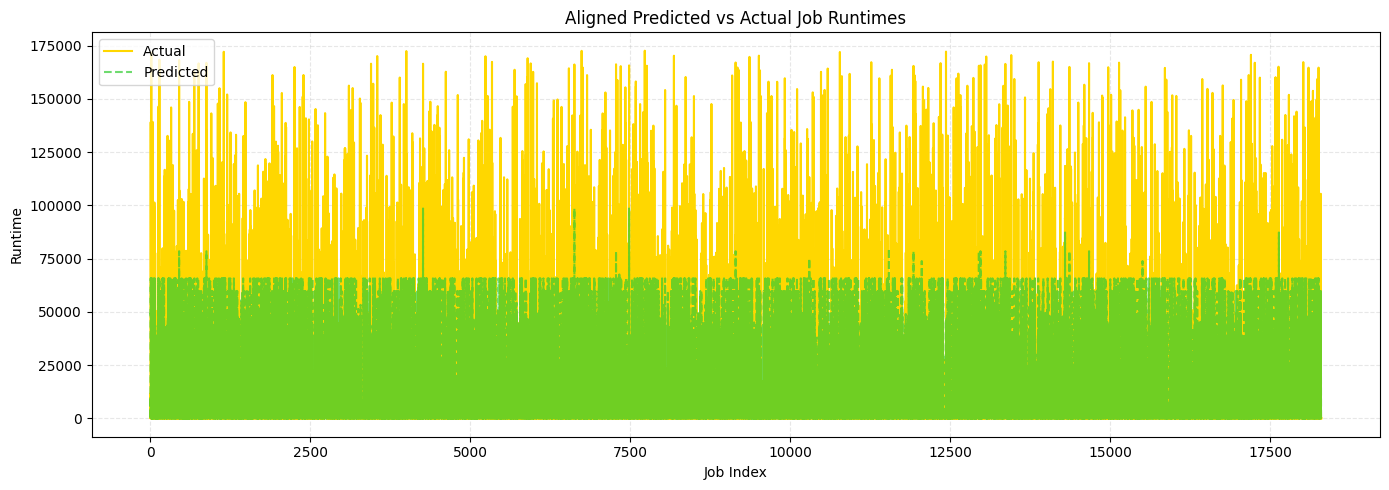

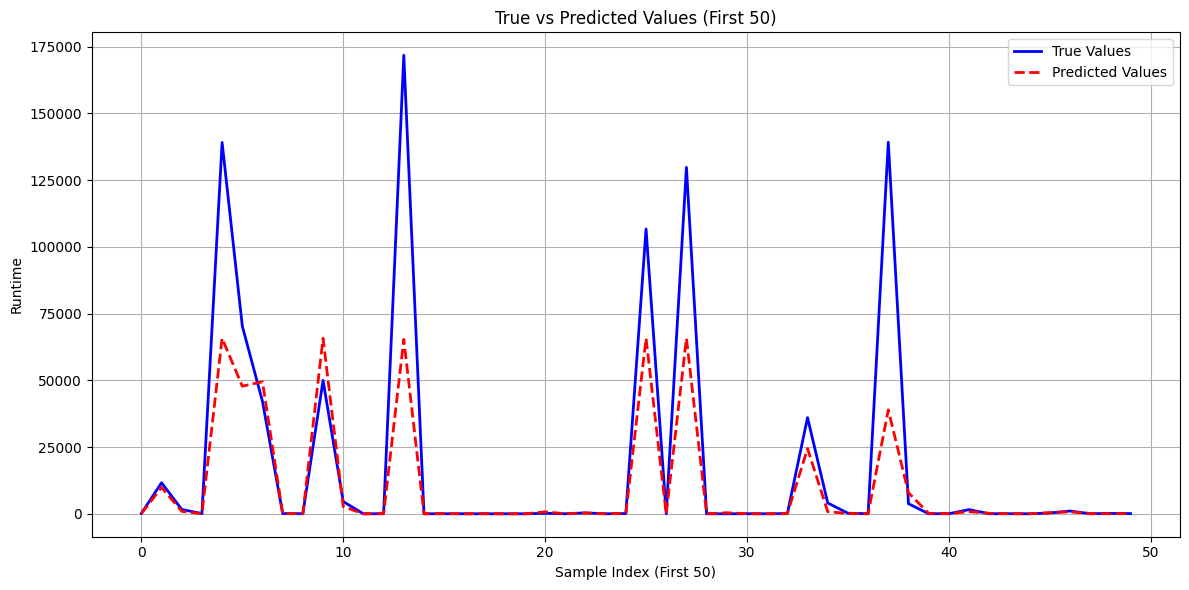

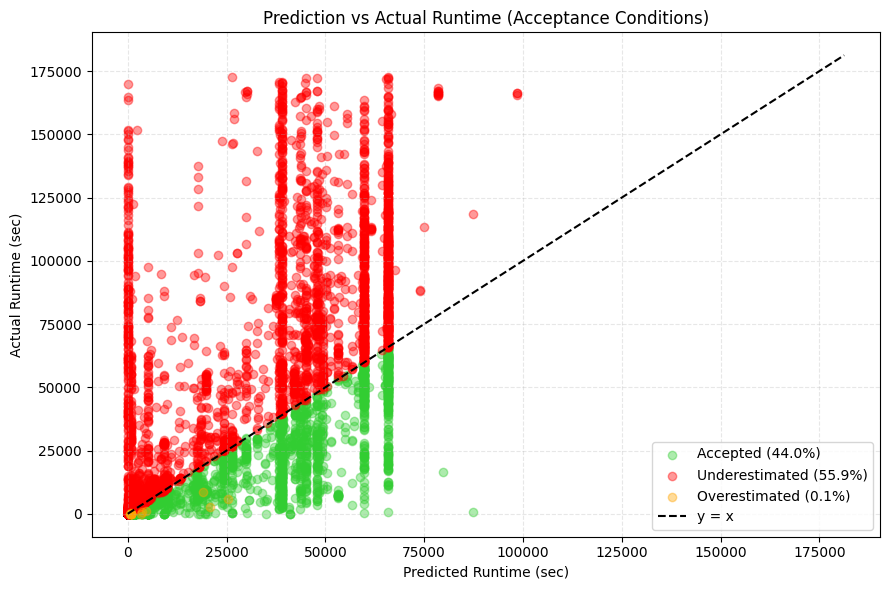


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.260
  MAE: 23117.88
  RMSE: 36984.04
  Samples: 5415

[Job Length medium]
  R²: -63.710
  MAE: 1097.55
  RMSE: 4120.07
  Samples: 1375

[Job Length short]
  R²: -112.298
  MAE: 172.06
  RMSE: 1284.31
  Samples: 11516


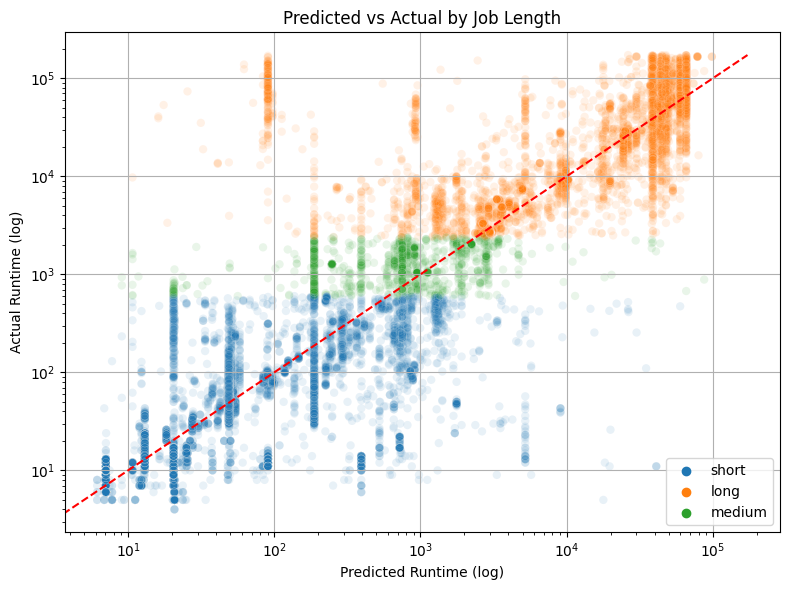


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: 0.468
  MAE: 11441.84
  RMSE: 25855.46
  Samples: 904

[Job Type distributed_gpu]
  R²: -0.022
  MAE: 4324.38
  RMSE: 7042.76
  Samples: 35

[Job Type multithreaded]
  R²: 0.440
  MAE: 18171.87
  RMSE: 33894.85
  Samples: 5085

[Job Type serial]
  R²: 0.669
  MAE: 2098.55
  RMSE: 8996.90
  Samples: 11854

[Job Type single_node_gpu]
  R²: 0.710
  MAE: 2100.50
  RMSE: 9851.91
  Samples: 428


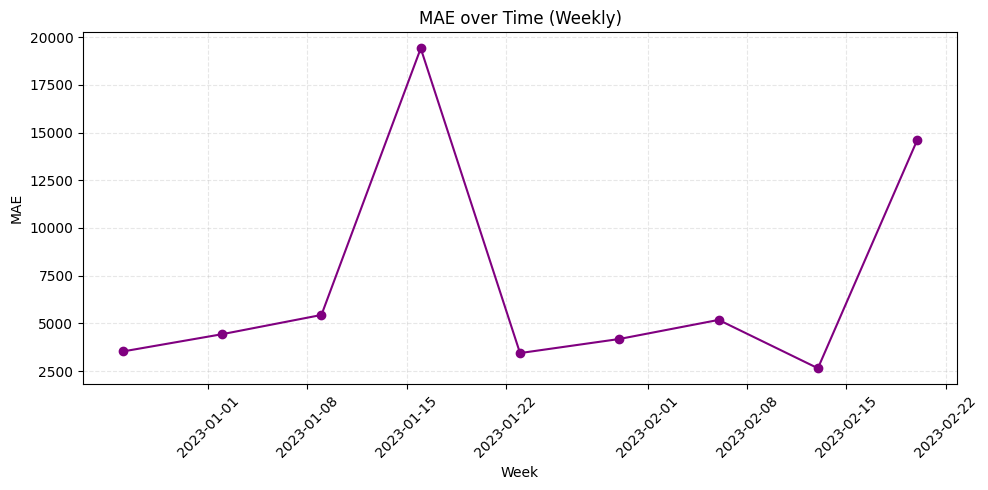

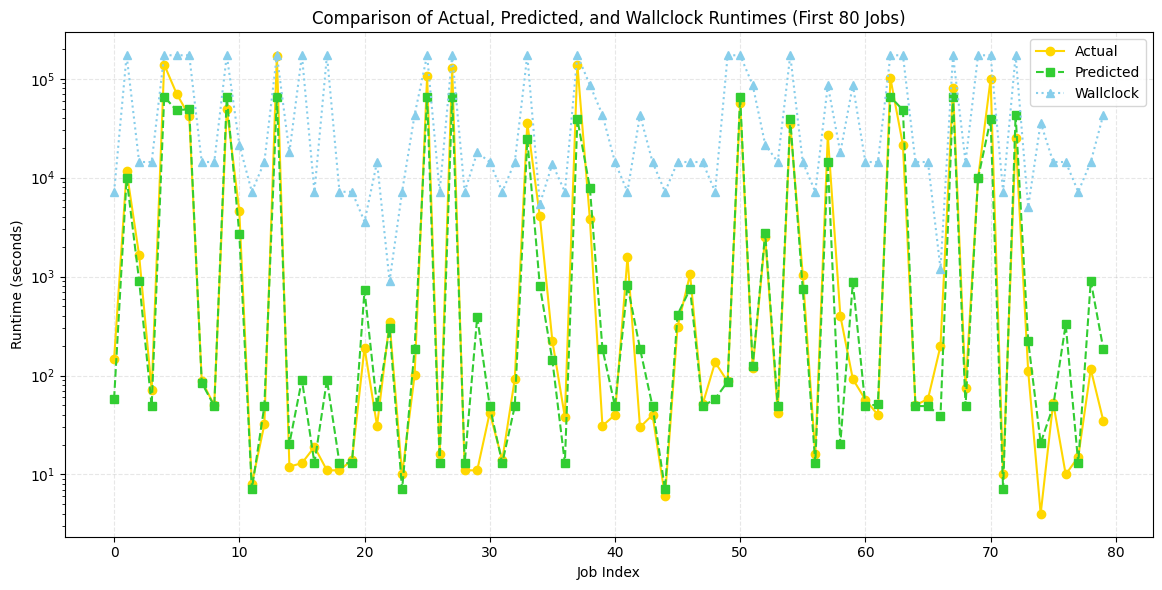

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

------ Evaluation: x_test ------
MAE       : 4678.04
RMSE      : 10638.79
R²        : 0.459
MedAE     : 348.19
Mean true : 8000.30
Total samples: 2937

⚠️  0 negative predictions (0.00%)


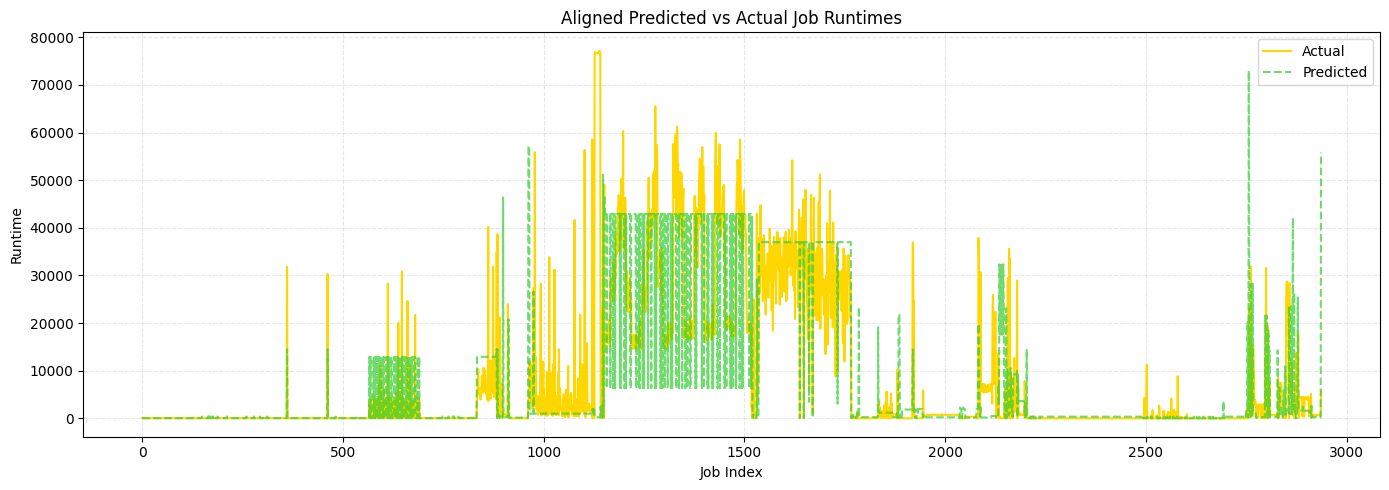

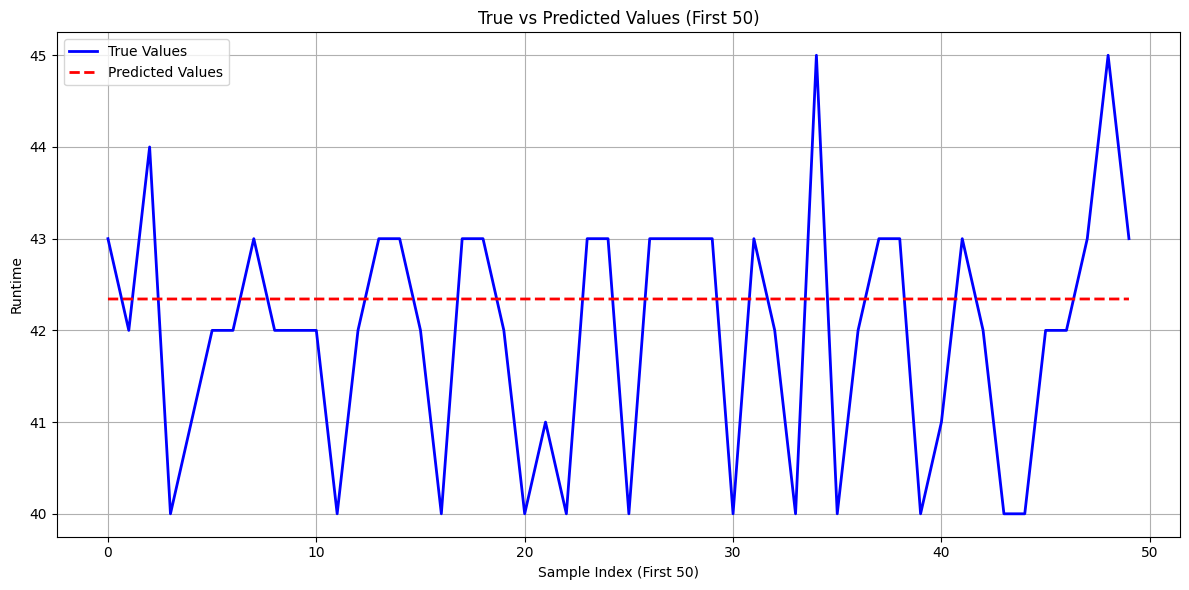

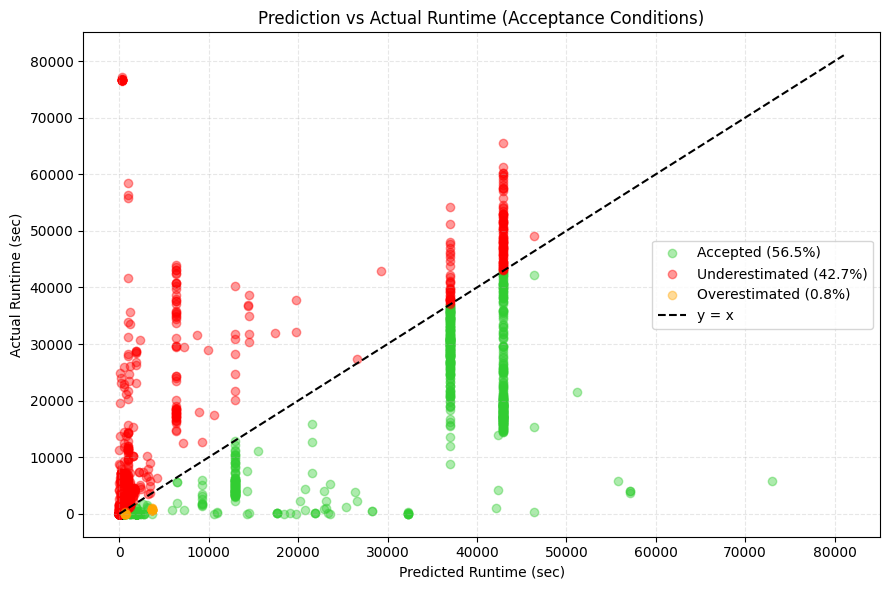


----- Per Job length Evaluation -----

[Job Length long]
  R²: -0.153
  MAE: 12283.78
  RMSE: 17572.23
  Samples: 1000

[Job Length medium]
  R²: -88.186
  MAE: 1597.71
  RMSE: 4545.57
  Samples: 274

[Job Length short]
  R²: -1307.592
  MAE: 612.06
  RMSE: 3287.77
  Samples: 1663


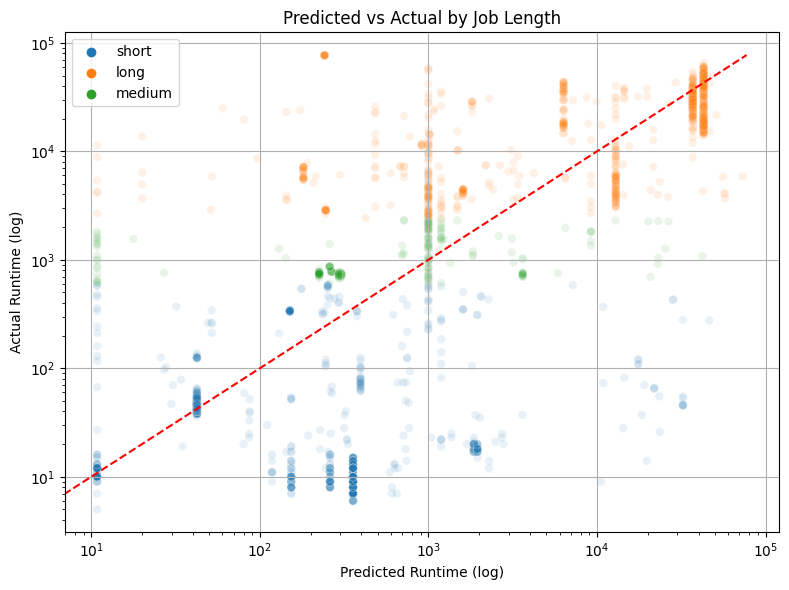


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: -2.507
  MAE: 8668.11
  RMSE: 14019.62
  Samples: 117

[Job Type distributed_gpu]
  R²: -0.809
  MAE: 3431.73
  RMSE: 4553.86
  Samples: 9

[Job Type multithreaded]
  R²: 0.150
  MAE: 8286.18
  RMSE: 16479.18
  Samples: 516

[Job Type serial]
  R²: 0.549
  MAE: 3659.68
  RMSE: 8619.99
  Samples: 2235

[Job Type single_node_gpu]
  R²: -2.069
  MAE: 3988.50
  RMSE: 7119.42
  Samples: 60

--- Day: 2023-02-20 | Samples: 1519 ---


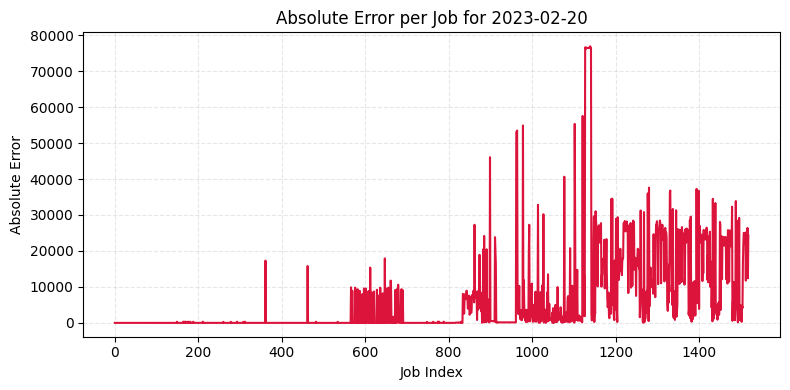

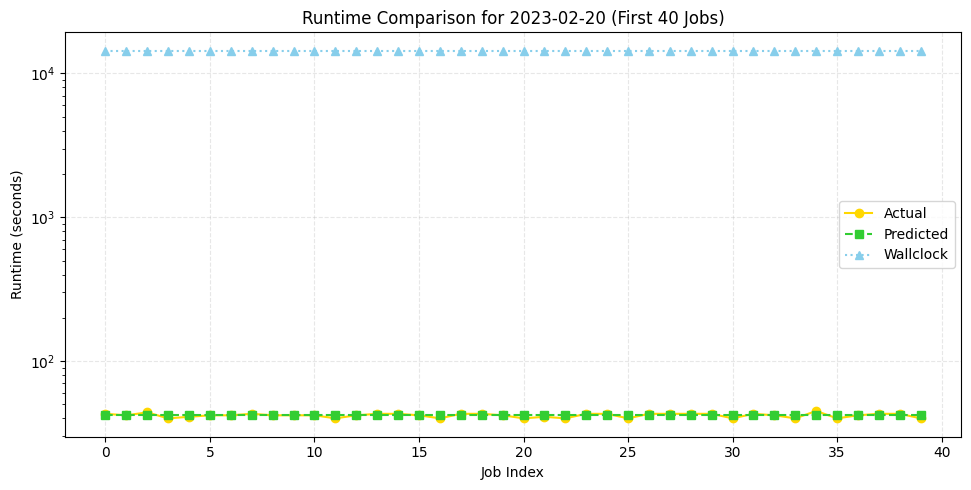


--- Day: 2023-02-21 | Samples: 1418 ---


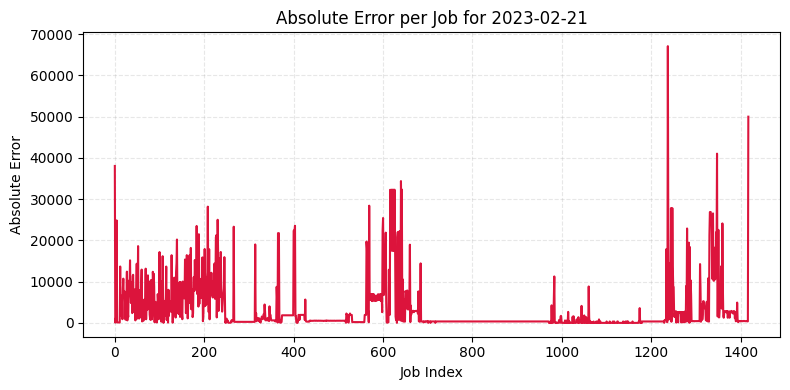

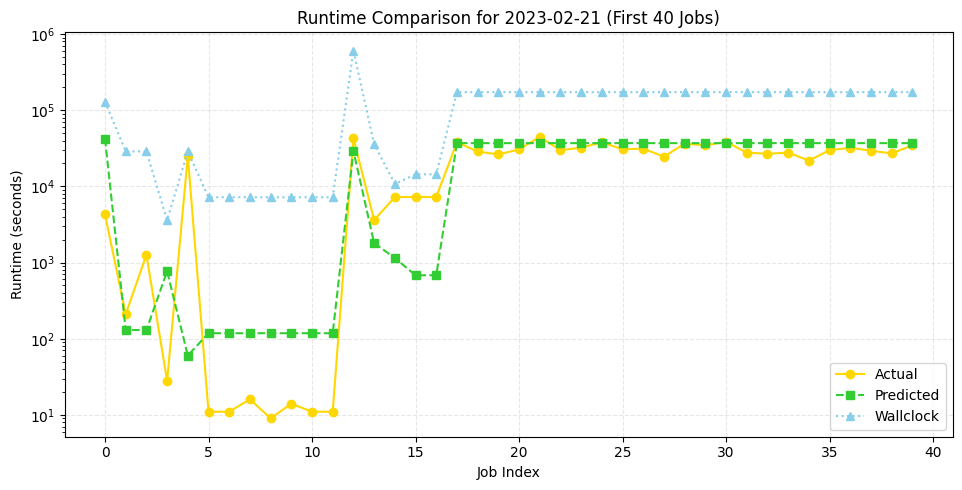

In [9]:
from tensorflow.keras.models import load_model
import joblib

# Custom RMSE metric for Keras
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Load model
from tensorflow.keras.losses import MeanSquaredError

# Create a dictionary for all custom functions used in compile()
custom_objects = {
    'rmse': rmse,
    'mse': MeanSquaredError()
}

# Load model
model = load_model('checkpoints_rnn_all_first_app/model_epoch_350.h5', custom_objects=custom_objects)

# Load scalers
X_scaler = joblib.load('checkpoints_rnn_all_first_app/x_scaler_epoch_350.pkl')
y_scaler = joblib.load('checkpoints_rnn_all_first_app/y_scaler_epoch_350.pkl')

import numpy as np

def prepare_and_predict(model, X_raw, X_scaler, y_scaler):
    # Step 1: Scale X
    X_scaled = X_scaler.transform(X_raw)

    # Step 2: Reshape for LSTM
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    return X_scaled



# f = ['partition_wallclock', 'cum_te_partition_qos', 'partition_qos_max_runtime_seen', 'program_type_job_type_qos_partition_ratio_runtime_ema','last_run_time_1','last_run_time_2','last_run_time_3','last_run_time_4','last_run_time_5']
f = ['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes',
'nodes_req_mem', 'processors_req_mem', 'partition_wallclock','last_run_time_1','last_run_time_2','last_run_time_3','last_run_time_4','last_run_time_5']

X_train_scaled = prepare_and_predict(model, X_train_final[f], X_scaler, y_scaler)
X_test_scaled  = prepare_and_predict(model, X_test_final[f], X_scaler, y_scaler)


evaluate_rnn_model(model, X_train_scaled, y_train, label='x_train', scaler_y=y_scaler, raw_X=X_train)
evaluate_rnn_model(model, X_test_scaled, y_test, label='x_test', scaler_y=y_scaler, raw_X=X_test)


## Save RNN ( model + scalers )

In [ ]:
# model.save('model_RNN.h5')
# import joblib

# # Suppose you used these
# joblib.dump(X_scaler, 'X_scaler_RNN.pkl')
# joblib.dump(y_scaler, 'y_scaler_RNN.pkl')